In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visual things.

# Things related to ML.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
plt.style.use('_mpl-gallery')

In [36]:
base = "/kaggle/input/store-sales-time-series-forecasting/"
train = pd.read_csv(base + "train.csv")
stores = pd.read_csv(base + "stores.csv")
test = pd.read_csv(base + "test.csv")
transactions = pd.read_csv(base + "transactions.csv")
oil = pd.read_csv(base + "oil.csv")
holidays = pd.read_csv(base + "holidays_events.csv")
print(train.isna().values.any())
print(stores.isna().values.any())
print(test.isna().values.any())
print(transactions.isna().values.any())
print(holidays.isna().values.any())
print("Oil-set has missing values: \n", oil.isna().sum())

False
False
False
False
False
Oil-set has missing values: 
 date           0
dcoilwtico    43
dtype: int64


It seems that there is missing values only in the oil-dataset. Let's first concentrate on the main dataset, also train. Let's look, how the different information about
that specific day affects the sales.

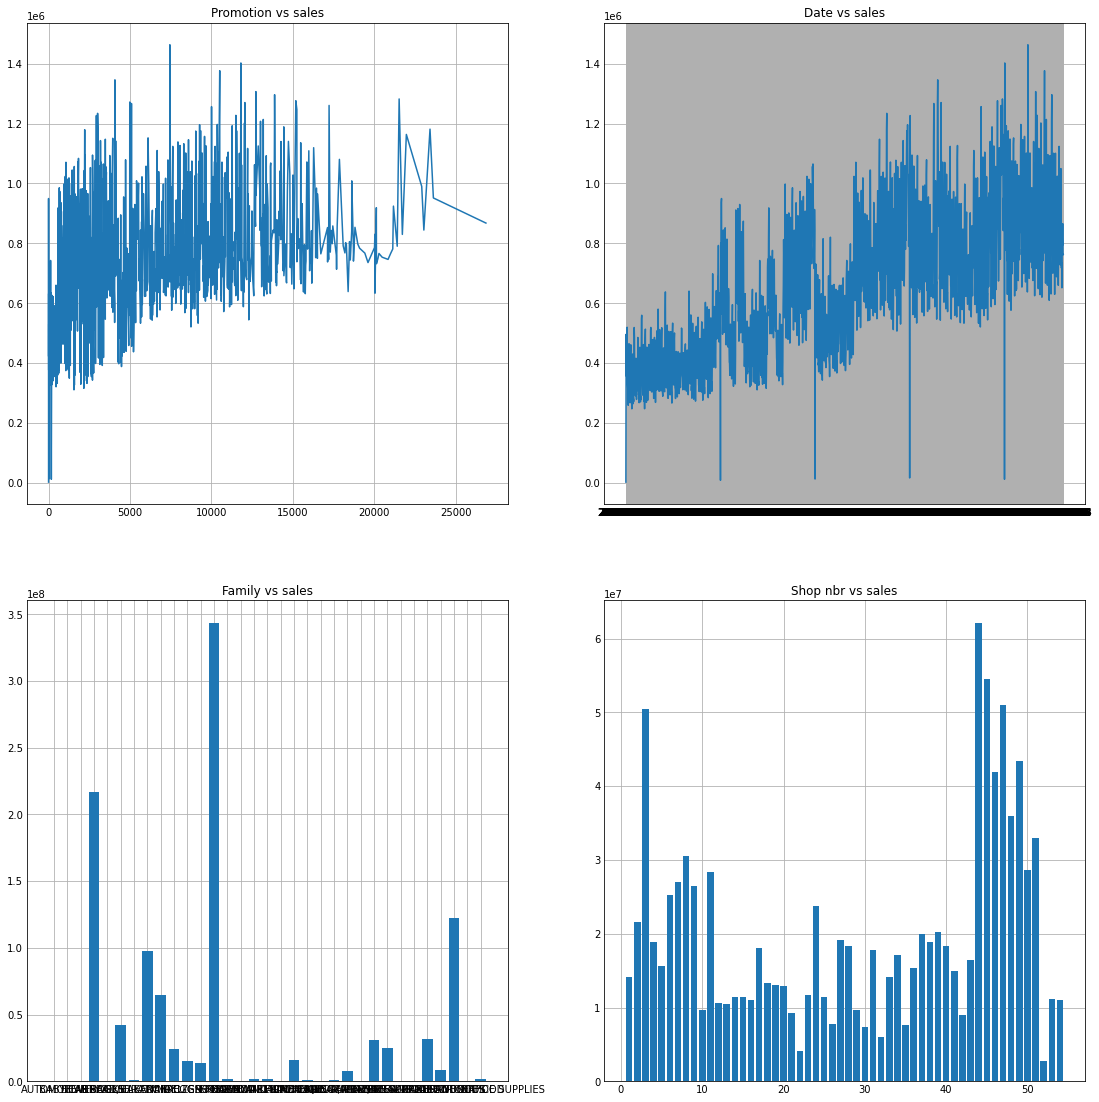

In [37]:
train_bydate = train.copy().groupby(["date"]).sum()

train_sorted = train_bydate.sort_values(by=["onpromotion"])
train_bystorenbr = train.groupby(["store_nbr"]).sum()
train_byfamily = train.groupby(["family"]).sum()

figure, axis = plt.subplots(2, 2,figsize=(15,15))
axis[0, 0].plot(train_sorted["onpromotion"], train_sorted["sales"])
axis[0, 0].set_title("Promotion vs sales")

axis[0, 1].plot(train_bydate.index, train_bydate["sales"])
axis[0, 1].set_title("Date vs sales")

axis[1, 0].bar(train_byfamily.index, train_byfamily["sales"])
axis[1, 0].set_title("Family vs sales")

axis[1, 1].bar(train_bystorenbr.index, train_bystorenbr["sales"])
axis[1, 1].set_title("Shop nbr vs sales")

plt.show()

Promotion and date (expected) are linear features of the sales, shop and family are categorical. Let's one-hot encode the shop and family features.

In [47]:
train["family"] = train['family'].astype('category')
cat_columns = train.select_dtypes(['category']).columns
train[cat_columns] = train[cat_columns].apply(lambda x: x.cat.codes)

test["family"] = test['family'].astype('category')
cat_columns2 = test.select_dtypes(['category']).columns
test[cat_columns2] = test[cat_columns2].apply(lambda x: x.cat.codes)

train.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,0,0.0,0
1,1,2013-01-01,1,1,0.0,0
2,2,2013-01-01,1,2,0.0,0
3,3,2013-01-01,1,3,0.0,0
4,4,2013-01-01,1,4,0.0,0


In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(train.drop(["sales", "date"], axis=1), train["sales"], test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_prediction = lr.predict(X_test)
score=r2_score(Y_test,Y_prediction)
print("r2 socre is ",score)

r2 socre is  0.1928963877351514


Prepare the submission and send it.

In [54]:
X_final = test.drop(["date"], axis=1)
Y_final = lr.predict(X_final)
output = pd.DataFrame({ "id": test["id"], "sales": Y_final })
output = output.set_index("id")
output.to_csv("submission.csv", index=False)